In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as sstat
from mpmath import mp
import math
import random
from scipy.stats import multivariate_normal
from sklearn import preprocessing as p

psd = pd.DataFrame
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

##MODELLO:

PRIOR DISTRIBUTION:

$ a \sim \mathcal{Unif}([0,10])$

$ b \sim \mathcal{Unif}([0,10])$

$ g \sim \mathcal{Unif}([0,10])$

$ k \sim \mathcal{Unif}([0,10])$

In [2]:
def prior_unif():
  return tfd.Uniform(0,10)

In [3]:
def prior_out(a,b,g,k):
  a_prior = tfd.Uniform(0,10).prob(a)
  b_prior = tfd.Uniform(0,10).prob(b)
  g_prior = tfd.Uniform(0,10).prob(g)
  k_prior = tfd.Uniform(0,10).prob(k)
  return  a_prior *b_prior * g_prior*  k_prior 

# KERNEL:

In [4]:
def my_kernel(u):
  return 1/(np.sqrt(2*math.pi))*np.exp(-1/2*u**2)

In [5]:
def K_h(u,h):
  return my_kernel(u/h)/h

In [6]:
def multivariate_kernel(u,H):
  det= np.linalg.det(H)
  uu = np.linalg.inv(H)* u
  KK= my_kernel(uu)
  return (1/det)*KK

# SUMMARY:

In [7]:
def S2(y):
  quantiles= np.zeros(9)
  for i in range(9):
      quantiles[i]= np.quantile(y,0.1+0.1*i)       #quantili 0,1 0,2 0,3 0,4 0,5 0,6 0,7 0,8 0,9
  return quantiles

In [8]:
def S1(y):
  summary = np.zeros(11)
  summary[0]= y[0]
  for i in range(10):
      summary[i+1]=y[((i+1)*25)-1]
  return summary

# NORM:

In [9]:
from scipy.spatial import distance

def distance(s_old, s_obs):
   return np.linalg.norm(s_old-s_obs)
   # return distance.mahalanobis(s_old, s_obs, iv)

      

##QUANTILE FUNCTION:

$ a + b (1+0.8\left(\frac{1-\mathcal{exp}(-g\mathcal{z}(r))}{1+exp(-g\mathcal{z}(r))}\right)(1+\mathcal{z}(r)^{2})^k\mathcal{z}(r)$

where

$\mathcal{z}(r) \sim \mathcal{N}(0,1)$

In [10]:
def quantile_fun(a,b,g,k,z):
    y = a+b*(1+0.8*(1-np.exp(-g*z))/(1+np.exp(-g*z)))*((1+z**2)**k)*z
    return y
      

## ABC ALGORITHM:

INITIALIZATION:

$\mathcal{z}^{0}(r) \sim \mathcal{N}(0,1)$

$ a^{(0)} \sim \mathcal{Unif}([0,10])$

$ b^{(0)} \sim \mathcal{Unif}([0,10])$

$ g^{(0)} \sim \mathcal{Unif}([0,10])$

$ k^{(0)} \sim \mathcal{Unif}([0,10])$

$ y^{(0)} \sim \mathcal{quantile function}(\mathcal{z}^{0}(r))$

compute the summaries statistics:
$s_a,s_b,s_g, s_k$
QUANTILI DI Y??????????????'





Untill $Kh(||s^{(0)}−s_{obs}||)>0$
- Generate $\theta^{(0)} \sim \mathcal{Unif}([0,10]^{4})$ from prior density.
- Generate a sample of 1000 observations such that $y ∼ \mathcal{quantile function}$
- Compute $s^{(0)}=S(y)$



for i in (1,...,n):

1. RANDOM WALK:

    given $\ \theta^{(i-1)}=(a^{(i-1)},b^{(i-1)},g^{(i-1)},k^{(i-1)})$

    $\theta^{(i)} \sim \mathcal{N}(\theta^{(i-1)},I)$

    $\mathcal{z}^{i}(r) \sim \mathcal{N}(0,1)$

    $ y^{(i)} \sim \mathcal{quantile function}(\mathcal{z}^{i}(r))$

    $ s^{(i)} =S(y^{(i)})$

2. Accept $\tau^{(i)}$ with probability $Kh(||s^{(i)}−s_{obs}||)π(\theta^{(i)})/Kh(||s^{(i-1)}−s_{obs}||)\pi(\theta^{(i-1)})$ 



In [37]:
#SINGOLO PARAMETRO

def abc_algo_single_a (N, S, y_obs,h):
    s_obs = S(y_obs)
    s = np.zeros((N+1,9))
    y = np.zeros(n)
    y_current = np.zeros(n)
    a = np.zeros(N+1)
    k=0
    a_0 =prior_unif().sample(1)
    for i in range(n):
      z = tfd.Normal(0,1).sample() 
      y[i]=quantile_fun(a_0,b_0,g_0,k_0,z)

    s_0 = S(y)
   
    H=h
    #while K_h(mahal(np.array(s_0),np.array(s_obs)),H)<=0:
    while K_h(distance(np.array(s_0),np.array(s_obs)),H)<=0:    
        a_0 =prior_unif().sample()
        for j in range(n):
          z = tfd.Normal(0,1).sample()
          y[j]=quantile_fun(a_0,b_0,g_0,k_0,z)
        s_0 = S(y)
   
    a[0]=a_0
    

    for i in range(N):
        
        a_current = tfd.Normal(a[i],1).sample()
        b_current = b_0
        g_current = g_0
        k_current = k_0      
        for j in range(n):
          z = tfd.Normal(0,1).sample() 
          y_current[j] = quantile_fun(a_current,b_current,g_current,k_current,z)
        s_current = S(y_current)

       
        #den_num=tfd.Normal(theta_muold,1).prob(theta_mucurrent)*tfd.Normal(theta_tauold,1).prob(theta_taucurrent)
        #den_den=tfd.Normal(theta_mucurrent,1).prob(theta_muold)*tfd.Normal(theta_taucurrent,1).prob(theta_tauold)
        
        NUM= (K_h(distance(np.array(s_current), np.array(s_obs)),H)* prior_unif().prob(a_current))
        DEN= (K_h(distance(np.array(s[i,]),np.array(s_obs)),H)* prior_unif().prob(a[i]))
       
        prob = min([1.,NUM/DEN])
      
        u = tfd.Uniform(0,1).sample()
        if u < prob:
              a[i+1]=a_current
              s[i+1,]=s_current
              k+=1
        else: 
              a[i+1]=a[i]
              s[i+1,]=s[i,]

        
    return a, k

In [21]:
#GOLO PARAMETRO

def abc_algo_single (N, S, y_obs,h):
    s_obs = S(y_obs)
    s = np.zeros((N+1,9))
    y = np.zeros(n)
    y_current = np.zeros(n)
    g = np.zeros(N+1)
    k=0
    g_0 =prior_unif().sample(1)
    for i in range(n):
      z = tfd.Normal(0,1).sample() 
      y[i]=quantile_fun(a_0,b_0,g_0,k_0,z)

    s_0 = S(y)
   
    H=h
    #while K_h(mahal(np.array(s_0),np.array(s_obs)),H)<=0:
    while K_h(distance(np.array(s_0),np.array(s_obs)),H)<=0:    
        g_0 =prior_unif().sample()
        for j in range(n):
          z = tfd.Normal(0,1).sample()
          y[j]=quantile_fun(a_0,b_0,g_0,k_0,z)
        s_0 = S(y)
   
    g[0]=g_0
    

    for i in range(N):
        
        a_current = a_0
        b_current = b_0
        g_current = tfd.Normal(g[i],0.31).sample()
        k_current = k_0      
        for j in range(n):
          z = tfd.Normal(0,1).sample() 
          y_current[j] = quantile_fun(a_current,b_current,g_current,k_current,z)
        s_current = S(y_current)

       
        #den_num=tfd.Normal(theta_muold,1).prob(theta_mucurrent)*tfd.Normal(theta_tauold,1).prob(theta_taucurrent)
        #den_den=tfd.Normal(theta_mucurrent,1).prob(theta_muold)*tfd.Normal(theta_taucurrent,1).prob(theta_tauold)
        
        NUM= (K_h(distance(np.array(s_current), np.array(s_obs)),H)* prior_unif().prob(g_current))
        DEN= (K_h(distance(np.array(s[i,]),np.array(s_obs)),H)* prior_unif().prob(g[i]))
       
        prob = min([1.,NUM/DEN])
      
        u = tfd.Uniform(0,1).sample()
        if u < prob:
              g[i+1]=g_current
              s[i+1,]=s_current
              k+=1
        else: 
              g[i+1]=g[i]
              s[i+1,]=s[i,]

        
    return g, k

In [12]:
def abc_algo (N, S, y_obs,h):
    s_obs = S(y_obs)
    s = np.zeros((N+1,9))
    y = np.zeros(n)
    y_current = np.zeros(n)
    a = np.zeros(N+1)
    b = np.zeros(N+1)
    g = np.zeros(N+1)
    k = np.zeros(N+1)
    acc =0
    a_0,b_0,g_0,k_0 =prior_unif().sample(4)
    for i in range(n):
      z = tfd.Normal(0,1).sample() 
      y[i]=quantile_fun(a_0,b_0,g_0,k_0,z)

    s_0 = S(y)
   
    H=h
 
    while K_h(distance(np.array(s_0),np.array(s_obs)),H)<=0:    
        a_0,b_0,g_0,k_0 =prior_unif().sample(4)
        for j in range(n):
          z = tfd.Normal(0,1).sample()
          y[j]=quantile_fun(a_0,b_0,g_0,k_0,z)
        s_0 = S(y)
   
    a[0]=a_0
    b[0]=b_0
    g[0]=g_0
    k[0]=k_0
    s[0,]=s_0
    

    for i in range(N):
        
        a_current = tfd.Normal(a[i],1).sample()
        b_current = tfd.Normal(b[i],1).sample()
        g_current = tfd.Normal(g[i],1).sample()
        k_current = tfd.Normal(k[i],1).sample()
        
        for j in range(n):
          z = tfd.Normal(0,1).sample() 
          y_current[j] = quantile_fun(a_current,b_current,g_current,k_current,z)
        s_current = S(y_current)

       
        #den_num=tfd.Normal(theta_muold,1).prob(theta_mucurrent)*tfd.Normal(theta_tauold,1).prob(theta_taucurrent)
        #den_den=tfd.Normal(theta_mucurrent,1).prob(theta_muold)*tfd.Normal(theta_taucurrent,1).prob(theta_tauold)
        
        NUM= (K_h(distance(np.array(s_current), np.array(s_obs)),H)* prior_out(a_current,b_current,g_current,k_current))
        DEN= (K_h(distance(np.array(s[i,]),np.array(s_obs)),H)* prior_out(a[i],b[i],g[i],k[i]))
       
        prob = min([1.,NUM/DEN])
      
        u = tfd.Uniform(0,1).sample()
        if u < prob:
              a[i+1]=a_current
              b[i+1]=b_current
              g[i+1]=g_current
              k[i+1]=k_current
              s[i+1]=s_current
              acc +=1
        else: 
              a[i+1]=a[i]
              b[i+1]=b[i]
              g[i+1]=g[i]
              k[i+1]=k[i]
              s[i+1,]=s[i,]

        
    return a,b,g,k

# APPLICAZIONE:

testiamo con le seguenti variabili:

In [23]:
aobs = 3
bobs =1
gobs =2
kobs=0.5
n= 100
h=0.1
y_obs = np.zeros(n)
for i in range(n):
  z = tfd.Normal(0,1).sample() 
  y_obs[i] = quantile_fun(aobs,bobs,gobs,kobs,z)

In [24]:
g_0 =2
b_0 =1
k_0=0.5

In [38]:
a_post, acc = abc_algo_single_a (1000, S2, y_obs, h)  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in double_scalars


###### CHECK


In [ ]:
a_post=prova[0]
b_post=prova[1]
g_post=prova[2]
k_post=prova[3]

In [26]:
np.mean(prova[200:])

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [20]:
np.unique(prova[0:200])

array([2.31540826, 2.34833568, 2.40879631, 2.57859454, 2.5788316 ,
       3.06784058, 3.22507736, 3.22782516, 3.3638218 ])

In [39]:
np.mean(a_post)

3.1044888317026964

In [40]:
acc


10

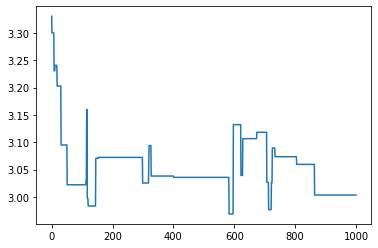

In [36]:
plt.plot(a_post)

In [ ]:
np.mean(g_post)

1.8713173119344035

In [ ]:
np.mean(k_post)

1.3594015984433678

(array([14.,  0.,  0.,  0.,  1., 74.,  4.,  0.,  0.,  8.]),
 array([2.16346161, 2.33383195, 2.50420229, 2.67457263, 2.84494297,
        3.01531331, 3.18568365, 3.35605399, 3.52642433, 3.69679467,
        3.86716501]),
 <a list of 10 Patch objects>)

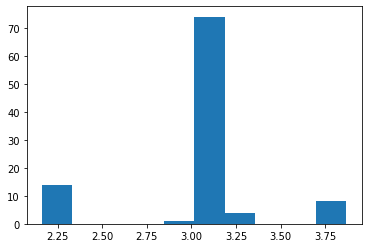

In [ ]:
plt.hist(a_post)

(array([291., 586., 115.,   1.,   1.,   1.,   3.,   0.,   0.,   3.]),
 array([2.64780437, 2.9004057 , 3.15300703, 3.40560835, 3.65820968,
        3.910811  , 4.16341233, 4.41601366, 4.66861498, 4.92121631,
        5.17381763]),
 <a list of 10 Patch objects>)

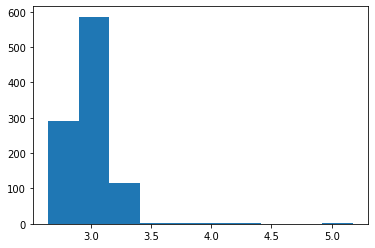

In [ ]:
plt.hist(prova)

In [ ]:
np.mean(k_post)

1.4417349810909619